# Sessa Empirical Estimator

## Setup

### Import Libraries and Set Paths

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

CSV_PATH = './csv-files/'

### Setup sample data

In [245]:
file_path = CSV_PATH + "med_events.csv"

# Try to read the CSV file into a DataFrame
try:
    med_events = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    
    # Convert date column to datetime (assuming 'DATE' is the column name in your CSV)
    med_events["DATE"] = pd.to_datetime(med_events["DATE"])

    # Change column names
    med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

    # Display the first few rows
    print(med_events.head())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Ensure the file exists.")



CSV file loaded successfully!
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


## Callable Functions

In [246]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd']).copy()  # Ensure a copy to prevent unintended modifications
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    
    # Ensure we work with a deep copy of the subset
    drug_see2 = arg1.dropna(subset=['prev_eksd']).copy()
    
    # Use .loc to avoid SettingWithCopyWarning
    drug_see2.loc[:, 'p_number'] = drug_see2.groupby('pnr').cumcount() + 1

    # Apply filtering with .loc to avoid unintended view modification
    drug_see2 = drug_see2.loc[drug_see2['p_number'] >= 2].copy()

    # Calculate duration
    drug_see2.loc[:, 'Duration'] = (drug_see2['eksd'] - drug_see2['prev_eksd']).dt.days

    # Compute median of medians
    medians_of_medians = drug_see2.groupby('pnr')['Duration'].median().median()

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=drug_see2)
    plt.axhline(medians_of_medians, linestyle='--', color='red')
    plt.show()


In [247]:
def see(arg1):
    # Filter dataset based on input argument
    c09ca01 = example_pats[example_pats['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()

    # Sort by 'pnr' and 'eksd', then compute previous event date
    drug_see_p1 = drug_see_p1.sort_values(by=['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)

    # Use assignment instead of inplace dropna
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])

    # Fix deprecated .apply() usage
    drug_see_p1 = drug_see_p1.sample(frac=1).groupby('pnr', group_keys=False).head(1).reset_index(drop=True)

    # Compute event interval in days (ensure it's an integer)
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(int)

    # Compute ECDF and determine threshold for 80th percentile
    ecdf = drug_see_p1['event_interval'].value_counts().sort_index().cumsum() / len(drug_see_p1)
    dfper = ecdf[ecdf <= 0.8].reset_index()
    dfper.columns = ['x', 'y']
    ni = dfper['x'].max()

    # Filter dataset based on threshold
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni]

    # Estimate density using Gaussian KDE
    density = gaussian_kde(np.log(drug_see_p2['event_interval']))
    x_vals = np.linspace(np.log(drug_see_p2['event_interval']).min(), np.log(drug_see_p2['event_interval']).max(), 1000)
    y_vals = density(x_vals)
    a = pd.DataFrame({'x': x_vals, 'y': y_vals})
    a = StandardScaler().fit_transform(a)

    # Clustering using KMeans
    silhouette_avg = silhouette_score(a, KMeans(n_clusters=2, random_state=1234).fit_predict(a))
    cluster = KMeans(n_clusters=2, random_state=1234).fit(dfper[['x']])
    dfper['cluster'] = cluster.labels_

    # Compute cluster statistics explicitly using .agg()
    nif = dfper.groupby('cluster').agg(Minimum=('x', 'min'), Maximum=('x', 'max'), Median=('x', 'median')).reset_index()

    # Merge cluster information
    results = drug_see_p1.merge(nif, how='cross')
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['Minimum']) & (results['event_interval'] <= results['Maximum']),
        results['cluster'],
        np.nan
    )

    # Use assignment instead of inplace dropna
    results = results.dropna(subset=['Final_cluster'])

    results['Median'] = np.exp(results['Median'])

    # Determine most common cluster
    t1 = results['cluster'].value_counts().idxmax()
    t1_merged = results[results['cluster'] == t1].iloc[0]

    # Merge with main dataset
    drug_see_p1 = drug_see_p1.merge(results[['pnr', 'Median', 'cluster']], on='pnr', how='left')

    # Fix inplace fillna usage
    drug_see_p1 = drug_see_p1.assign(
        Median=drug_see_p1['Median'].fillna(t1_merged['Median']),
        cluster=drug_see_p1['cluster'].fillna(0)
    )

    drug_see_p1['test'] = np.round(drug_see_p1['event_interval'] - drug_see_p1['Median'], 1)

    # Final merge
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'cluster']]
    drug_see_p0 = drug_see_p0.merge(drug_see_p3, on='pnr', how='left')

    # Fix inplace fillna usage
    drug_see_p0 = drug_see_p0.assign(
        Median=drug_see_p0['Median'].fillna(t1_merged['Median']),
        cluster=drug_see_p0['cluster'].fillna(0)
    )

    return drug_see_p0


In [248]:
def see_dbscan(arg1):
    # Preprocessing and filtering similar to the original function
    c09ca01 = example_pats[example_pats['ATC'] == arg1].copy()
    drug_see_p1 = c09ca01.sort_values(by=['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])

    # Compute event interval
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(int)

    # Normalize data before clustering
    X = drug_see_p1[['event_interval']]
    X_scaled = StandardScaler().fit_transform(X)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
    drug_see_p1['cluster'] = dbscan.fit_predict(X_scaled)

    # Compute cluster statistics
    cluster_stats = drug_see_p1.groupby('cluster')['event_interval'].agg(['min', 'max', 'median'])
    print("DBSCAN Cluster Statistics:\n", cluster_stats)

    # Visualizing Clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(drug_see_p1['event_interval'], drug_see_p1['cluster'], c=drug_see_p1['cluster'], cmap='viridis', alpha=0.6)
    plt.xlabel('Event Interval (days)')
    plt.ylabel('Cluster')
    plt.title('DBSCAN Clustering of Event Intervals')
    plt.colorbar(label='Cluster ID')
    plt.show()

    return drug_see_p1

## Execution

### Using K-Means

In [249]:
med_a = see("medA")
med_a

,pnr,eksd,perday,ATC,dur_original,Median,cluster
0,61,2020-01-02,4,medA,2,3.104298e+26,0.0
1,49,2020-01-06,3,medA,25,3.104298e+26,0.0
2,6,2020-01-08,6,medA,11,3.104298e+26,0.0
3,91,2020-01-11,1,medA,3,2.804290e+104,1.0
4,93,2020-01-12,5,medA,16,3.104298e+26,0.0
...,...,...,...,...,...,...,...
354,63,2022-09-19,1,medA,27,3.104298e+26,0.0
355,82,2022-09-20,1,medA,7,3.104298e+26,0.0
356,10,2022-09-21,4,medA,16,3.104298e+26,0.0
357,57,2022-09-24,3,medA,8,3.104298e+26,0.0


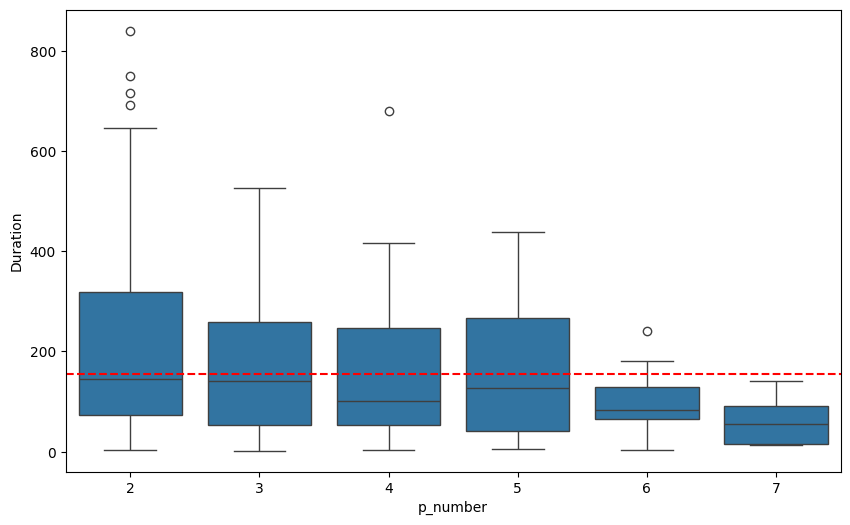

In [250]:
see_assumption(med_a)

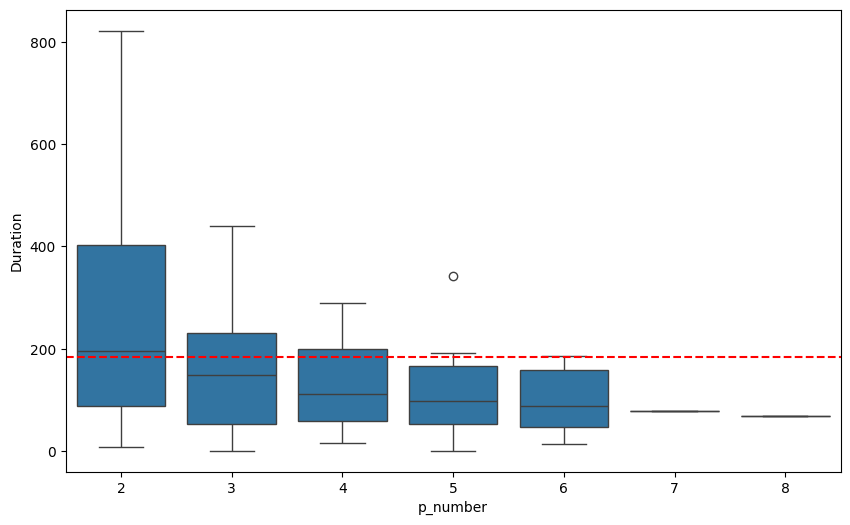

In [251]:
med_b = see("medB")
med_b

see_assumption(med_b)

### Using DBScan

DBSCAN Cluster Statistics:
          min  max  median
cluster                  
0          1  787   157.0


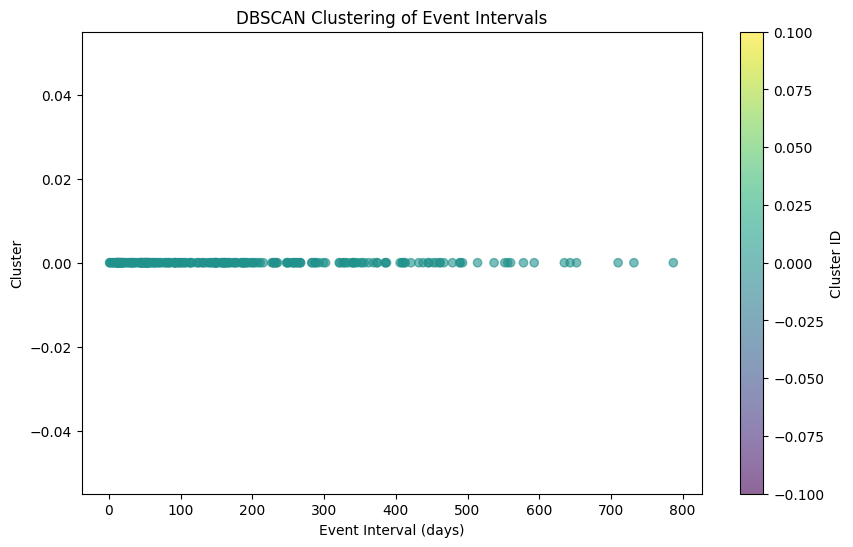

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval,cluster
487,1,2021-05-02,5,medC,17,2021-04-22,10,0
522,1,2021-06-06,4,medC,16,2021-05-02,35,0
896,1,2022-06-15,7,medC,3,2021-06-06,374,0
935,1,2022-07-24,6,medC,2,2022-06-15,39,0
47,2,2020-02-17,5,medC,6,2020-01-23,25,0
...,...,...,...,...,...,...,...,...
311,98,2020-11-07,2,medC,2,2020-09-23,45,0
407,99,2021-02-11,1,medC,21,2020-12-21,52,0
750,99,2022-01-20,7,medC,29,2021-02-11,343,0
828,99,2022-04-08,3,medC,2,2022-01-20,78,0


In [252]:
med_c = see("medC")
med_c

see_dbscan("medC")